# Ocean Colour Modelling Framework (OCMF)
This jupyter program is used to illustrate the Ocean Colour Modelling Framework (OCMF) proposed in Sun, Brewin et al. (submitted) for estimating remote sensing reflectance (Rrs) from chlorophyll-a concentration (Chl-a) and sea surface temperature (SST).

In [45]:
# loading packages
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [46]:
# loading py script for calculating backscattering of water (Zhang and Hu, 2009, https://doi.org/10.1364/OE.17.001671; Zhang et al., 2009, https://doi.org/10.1364/OE.17.005698)
import betasw124_ZHH2009

In [47]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Set up a dataset with Chl-a, SST, and salinity as inputs
Creates a dataset by pairing 50 Chl-a values (log-scaled from 0.01 to 10) with 30 SST values (linearly spaced from -1.8°C to 35°C), and adds a fixed salinity of 35 ppt to each pair. Can replace these with your own data or any other combination of values. Here the wavelength is set at 1-nm resolution within 400-700 nm.

In [49]:
num_chla = 50
num_sst = 30
chla = np.logspace(-2, 1, num=num_chla) 
sst = np.linspace(-1.8, 33, num=num_sst)
salinity = 35

data = pd.DataFrame(list(itertools.product(chla, sst)), columns=['TChl_a','SST'])
data.insert(2, 'Salinity', salinity)

wavelength = np.arange(700,399,-1)

### The OCMF explicitly incorperates the ecological model (Sun et al., 2023)
Here, SST-dependent models (i.e., 16- and 17-parameter models) are used in the OCMF that partition total Chl-a into size fractions. See Sun et al. (2023, https://doi.org/10.1016/j.rse.2022.113415) for more details. 

In [50]:
# calculate PSCs from Chl-a and SST
data_pscs = copy.deepcopy(data)

# 16-parameter Model
g1,g2,g3,g4 = -0.56,-3.79,1.92,-0.14
h1,h2,h3,h4 = -0.28,1.13,5.03,0.89
j1,j2,j3,j4 = 0.39,0.33,8.02,0.55 
k1,k2,k3,k4 = 0.65,0.22,12.79,0.09 

model_b_cnp = 1 - (g1/(1 + np.exp(-g2*(data_pscs.SST - g3))) + g4)
model_b_cp = 1 - (h1/(1 + np.exp(-h2*(data_pscs.SST - h3))) + h4)
model_b_dnp = j1/(1 + np.exp(-j2*(data_pscs.SST - j3))) + j4
model_b_dp = k1/(1 + np.exp(-k2*(data_pscs.SST - k3))) + k4

data_pscs['Cnp_16'] = model_b_cnp*(1-np.exp(-model_b_dnp/model_b_cnp*data_pscs.TChl_a))
data_pscs['Cp_16'] = model_b_cp*(1-np.exp(-model_b_dp/model_b_cp*data_pscs.TChl_a))
data_pscs['Cn_16'] = data_pscs['Cnp_16']-data_pscs['Cp_16']
data_pscs['Cm_16'] = data_pscs.TChl_a-data_pscs['Cnp_16']

data_pscs['Fp_16'] = data_pscs['Cp_16']/data_pscs.TChl_a
data_pscs['Fn_16'] = data_pscs['Cn_16']/data_pscs.TChl_a
data_pscs['Fm_16'] = data_pscs['Cm_16']/data_pscs.TChl_a
data_pscs['Fnp_16'] = data_pscs['Cnp_16']/data_pscs.TChl_a

#17-parameter Model
g1,g2,g3 = 0.003,-0.08,1.61 #cnp
h1,h2,h3,h4,h5,h6 = 0.52,12.71,8.95,0.30,27.52,4.61 #cp
j1,j2,j3,j4 =  0.39,0.33,8.02,0.55 #dnp
k1,k2,k3,k4 =  0.65,0.22,12.79,0.09 #dp

model_c_cnp = g1*data_pscs.SST*data_pscs.SST + g2*data_pscs.SST + g3
model_c_cp = h1*np.exp(-((data_pscs.SST-h2)/h3)**2) + h4*np.exp(-((data_pscs.SST-h5)/h6)**2)
model_c_dnp = j1/(1 + np.exp(-j2*(data_pscs.SST - j3)))+ j4
model_c_dp = k1/(1 + np.exp(-k2*(data_pscs.SST - k3)))+k4

data_pscs['Cnp_17'] = model_c_cnp*(1-np.exp(-model_c_dnp/model_c_cnp*data_pscs.TChl_a))
data_pscs['Cp_17'] = model_c_cp*(1-np.exp(-model_c_dp/model_c_cp*data_pscs.TChl_a))
data_pscs['Cn_17'] = data_pscs['Cnp_17']-data_pscs['Cp_17']
data_pscs['Cm_17'] = data_pscs.TChl_a-data_pscs['Cnp_17']

data_pscs['Fp_17'] = data_pscs['Cp_17']/data_pscs.TChl_a
data_pscs['Fn_17'] = data_pscs['Cn_17']/data_pscs.TChl_a
data_pscs['Fm_17'] = data_pscs['Cm_17']/data_pscs.TChl_a
data_pscs['Fnp_17'] = data_pscs['Cnp_17']/data_pscs.TChl_a

### Absorption
The total absorption coefficients, $a(\lambda)$, can be expressed as the additive sum of all particulate and dissolved absorbing components and water, such as: $a(\lambda)~=~a_w(\lambda)~+~a_{ph}(\lambda)~+~a_{d}(\lambda)~+~a_{g}(\lambda)$

In [51]:
# absorption of water-aw (Lee et al., 2015, https://doi.org/10.1364/AO.54.000546)
aw = pd.read_excel('input.xlsx')['aw']
model_aw = pd.DataFrame(data=aw.values.reshape(-1, 1).repeat(len(data), axis=1)).T
model_aw.columns = [i for i in map(str,wavelength)] 
data_aw = copy.deepcopy(data)
data_aw = pd.concat([data_aw, model_aw], axis=1)

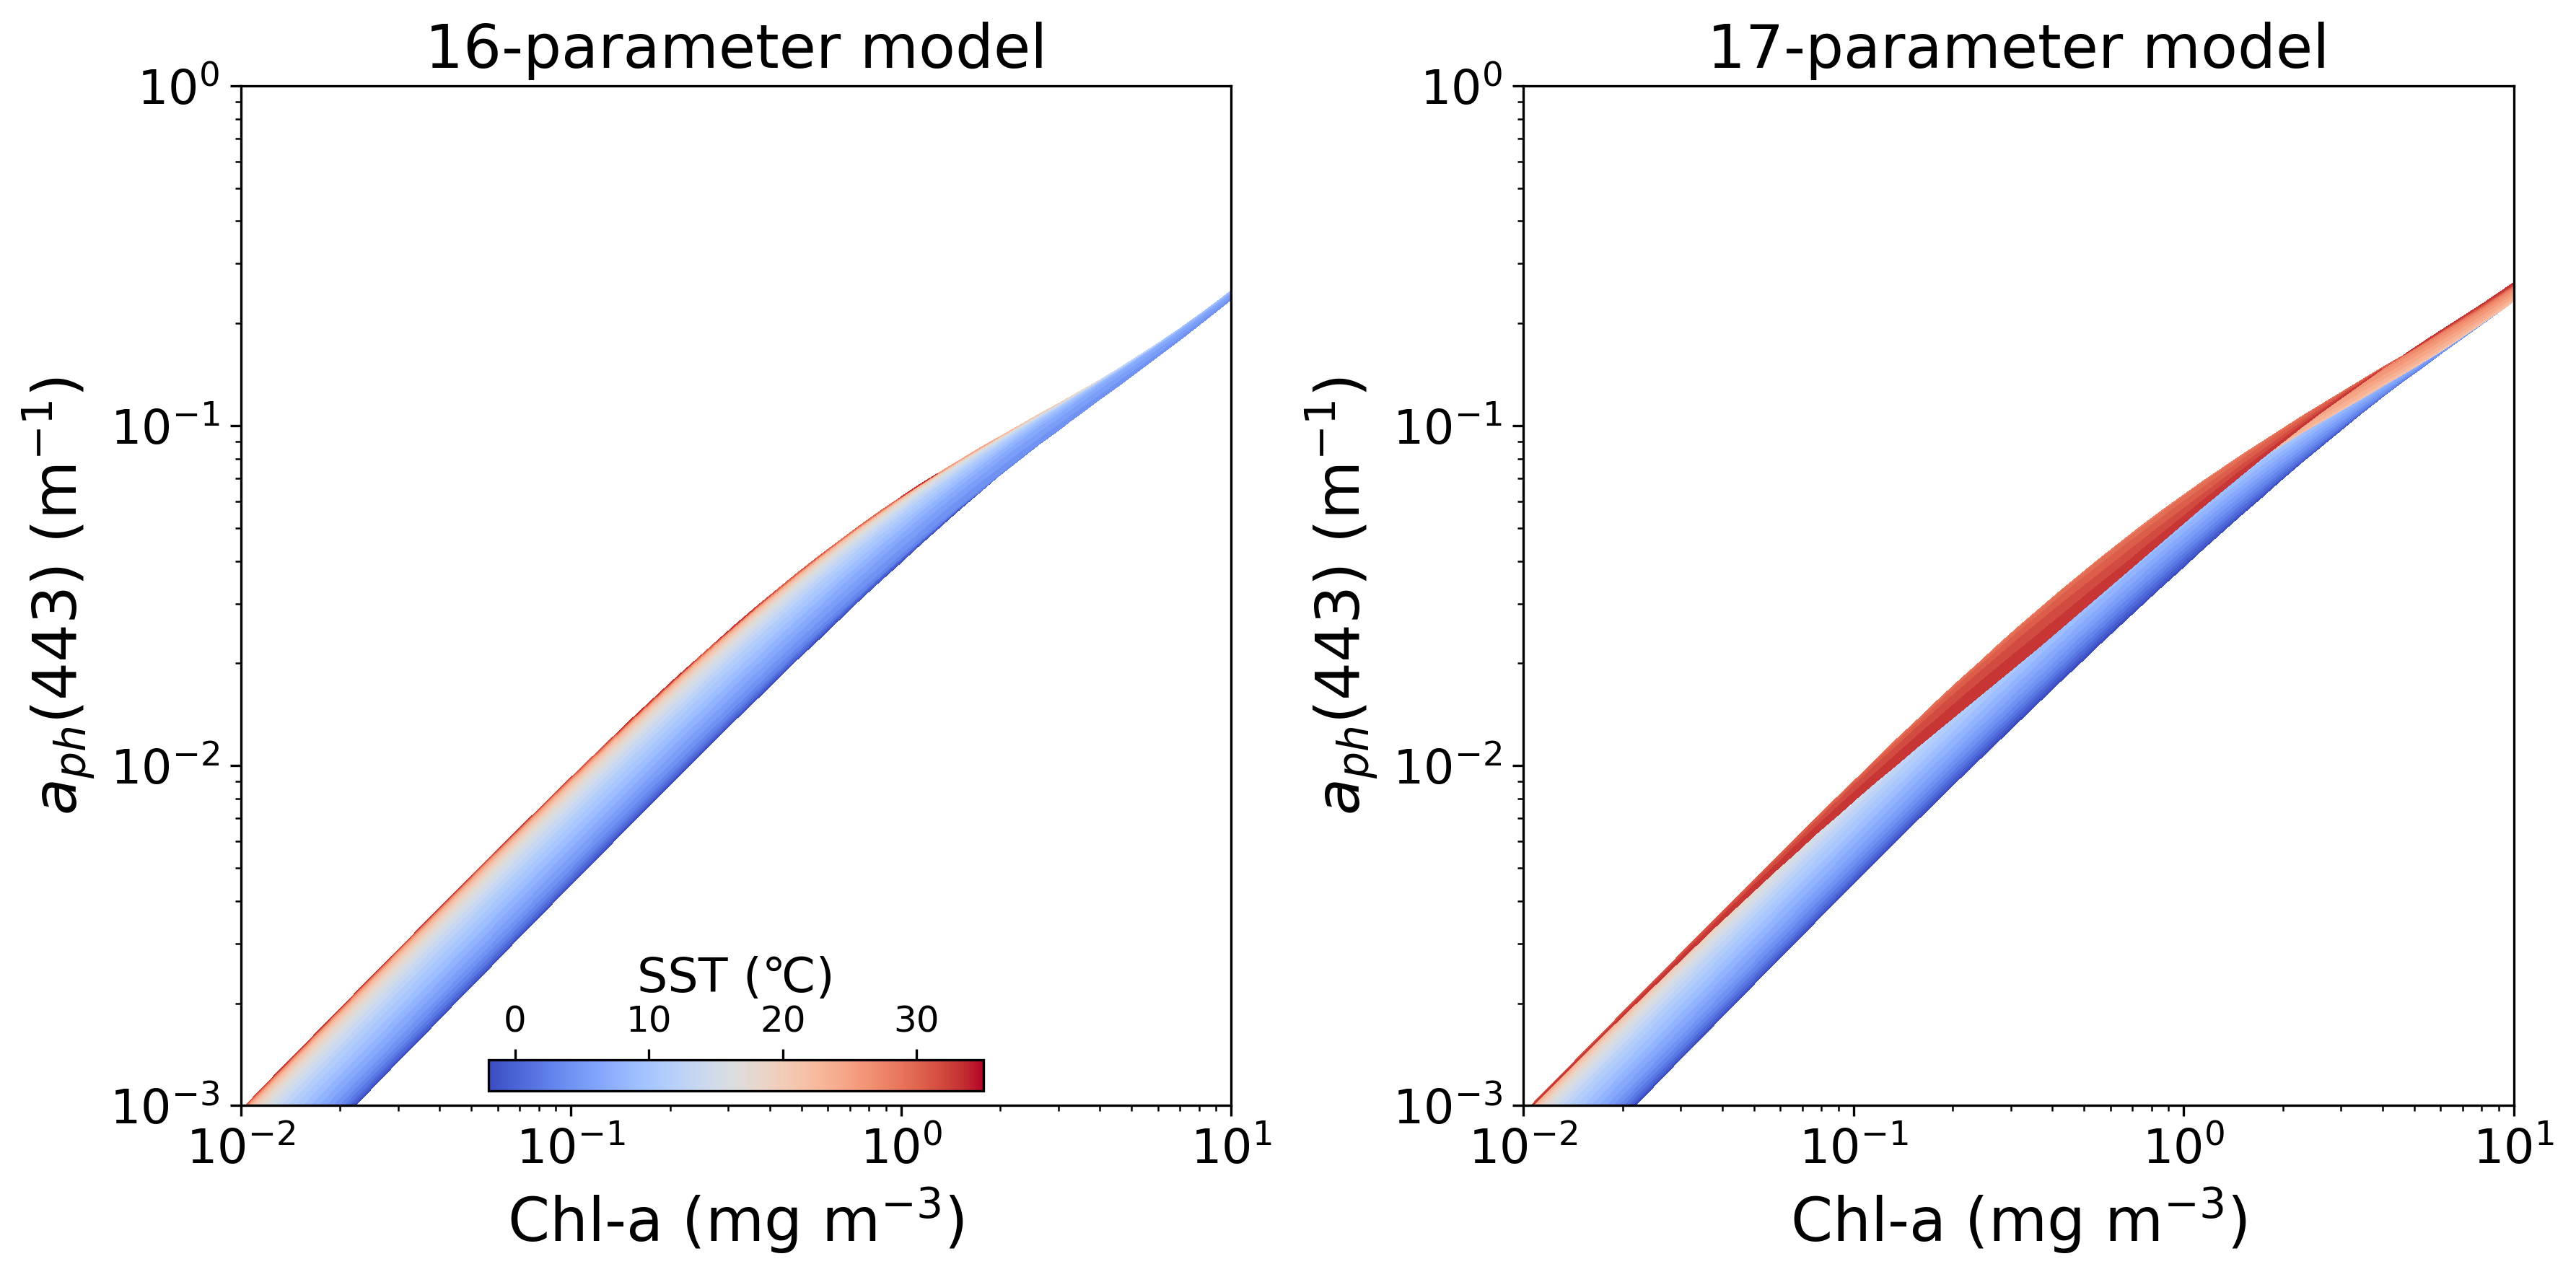

In [61]:
# absorption of phytoplankton-aph
# read chla-specific aph derived from this study
specific_aph_16 = pd.read_excel('input.xlsx', sheet_name='aph_16').iloc[:,1:]
specific_aph_17 = pd.read_excel('input.xlsx', sheet_name='aph_17').iloc[:,1:]

model_aph_16 = np.dot(specific_aph_16.loc[:,'Pico':'Micro'], data_pscs[['Cp_16','Cn_16','Cm_16']].T).T
model_aph_17 = np.dot(specific_aph_17.loc[:,'Pico':'Micro'], data_pscs[['Cp_17','Cn_17','Cm_17']].T).T

model_aph_16 = pd.DataFrame(model_aph_16, columns=[i for i in map(str,wavelength)])  
model_aph_17 = pd.DataFrame(model_aph_17, columns=[i for i in map(str,wavelength)])  

data_aph_16 = copy.deepcopy(data)
data_aph_16 = pd.concat([data_aph_16, model_aph_16], axis=1)

data_aph_17 = copy.deepcopy(data)
data_aph_17 = pd.concat([data_aph_17, model_aph_17], axis=1)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6),dpi=300)

cmap_sst = 'coolwarm'
norm_sst = mpl.colors.Normalize(vmin=-2, vmax=35)

axes[0].pcolormesh(np.reshape(data_aph_16['TChl_a'].values, (num_chla, num_sst)), np.reshape(data_aph_16['443'].values, (num_chla, num_sst)),np.reshape(data_aph_16['SST'].values, (num_chla, num_sst)), cmap=cmap_sst, norm=norm_sst)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Chl-a'+' ($\mathregular{mg~m^{-3}}$)', fontsize = 20)
axes[0].set_ylabel(r'$a_{ph}$'+'(443) ($\mathregular{m^{-1}}$)', fontsize = 20)
axes[0].set_xlim([0.01,10])
axes[0].set_ylim([0.001,1])
axes[0].xaxis.set_tick_params(labelsize=16)
axes[0].yaxis.set_tick_params(labelsize=16)
axes[0].set_title('16-parameter model', fontsize = 20)
axins1 = inset_axes(axes[0],
                    width="50%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower center')

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sst, cmap=cmap_sst), cax=axins1, orientation='horizontal',ticks = [0,10,20,30])
cb.ax.set_xticklabels(['0', '10', '20', '30']) 
cb.set_label(label='SST (℃)', size=16)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=12)

axes[1].pcolormesh(np.reshape(data_aph_17['TChl_a'].values, (num_chla, num_sst)), np.reshape(data_aph_17['443'].values, (num_chla, num_sst)),np.reshape(data_aph_17['SST'].values, (num_chla, num_sst)), cmap=cmap_sst, norm=norm_sst)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Chl-a'+' ($\mathregular{mg~m^{-3}}$)', fontsize = 20)
axes[1].set_ylabel(r'$a_{ph}$'+'(443) ($\mathregular{m^{-1}}$)', fontsize = 20)
axes[1].set_xlim([0.01,10])
axes[1].set_ylim([0.001,1])
axes[1].xaxis.set_tick_params(labelsize=16)
axes[1].yaxis.set_tick_params(labelsize=16)
axes[1].set_title('17-parameter model', fontsize = 20)

fig.tight_layout()

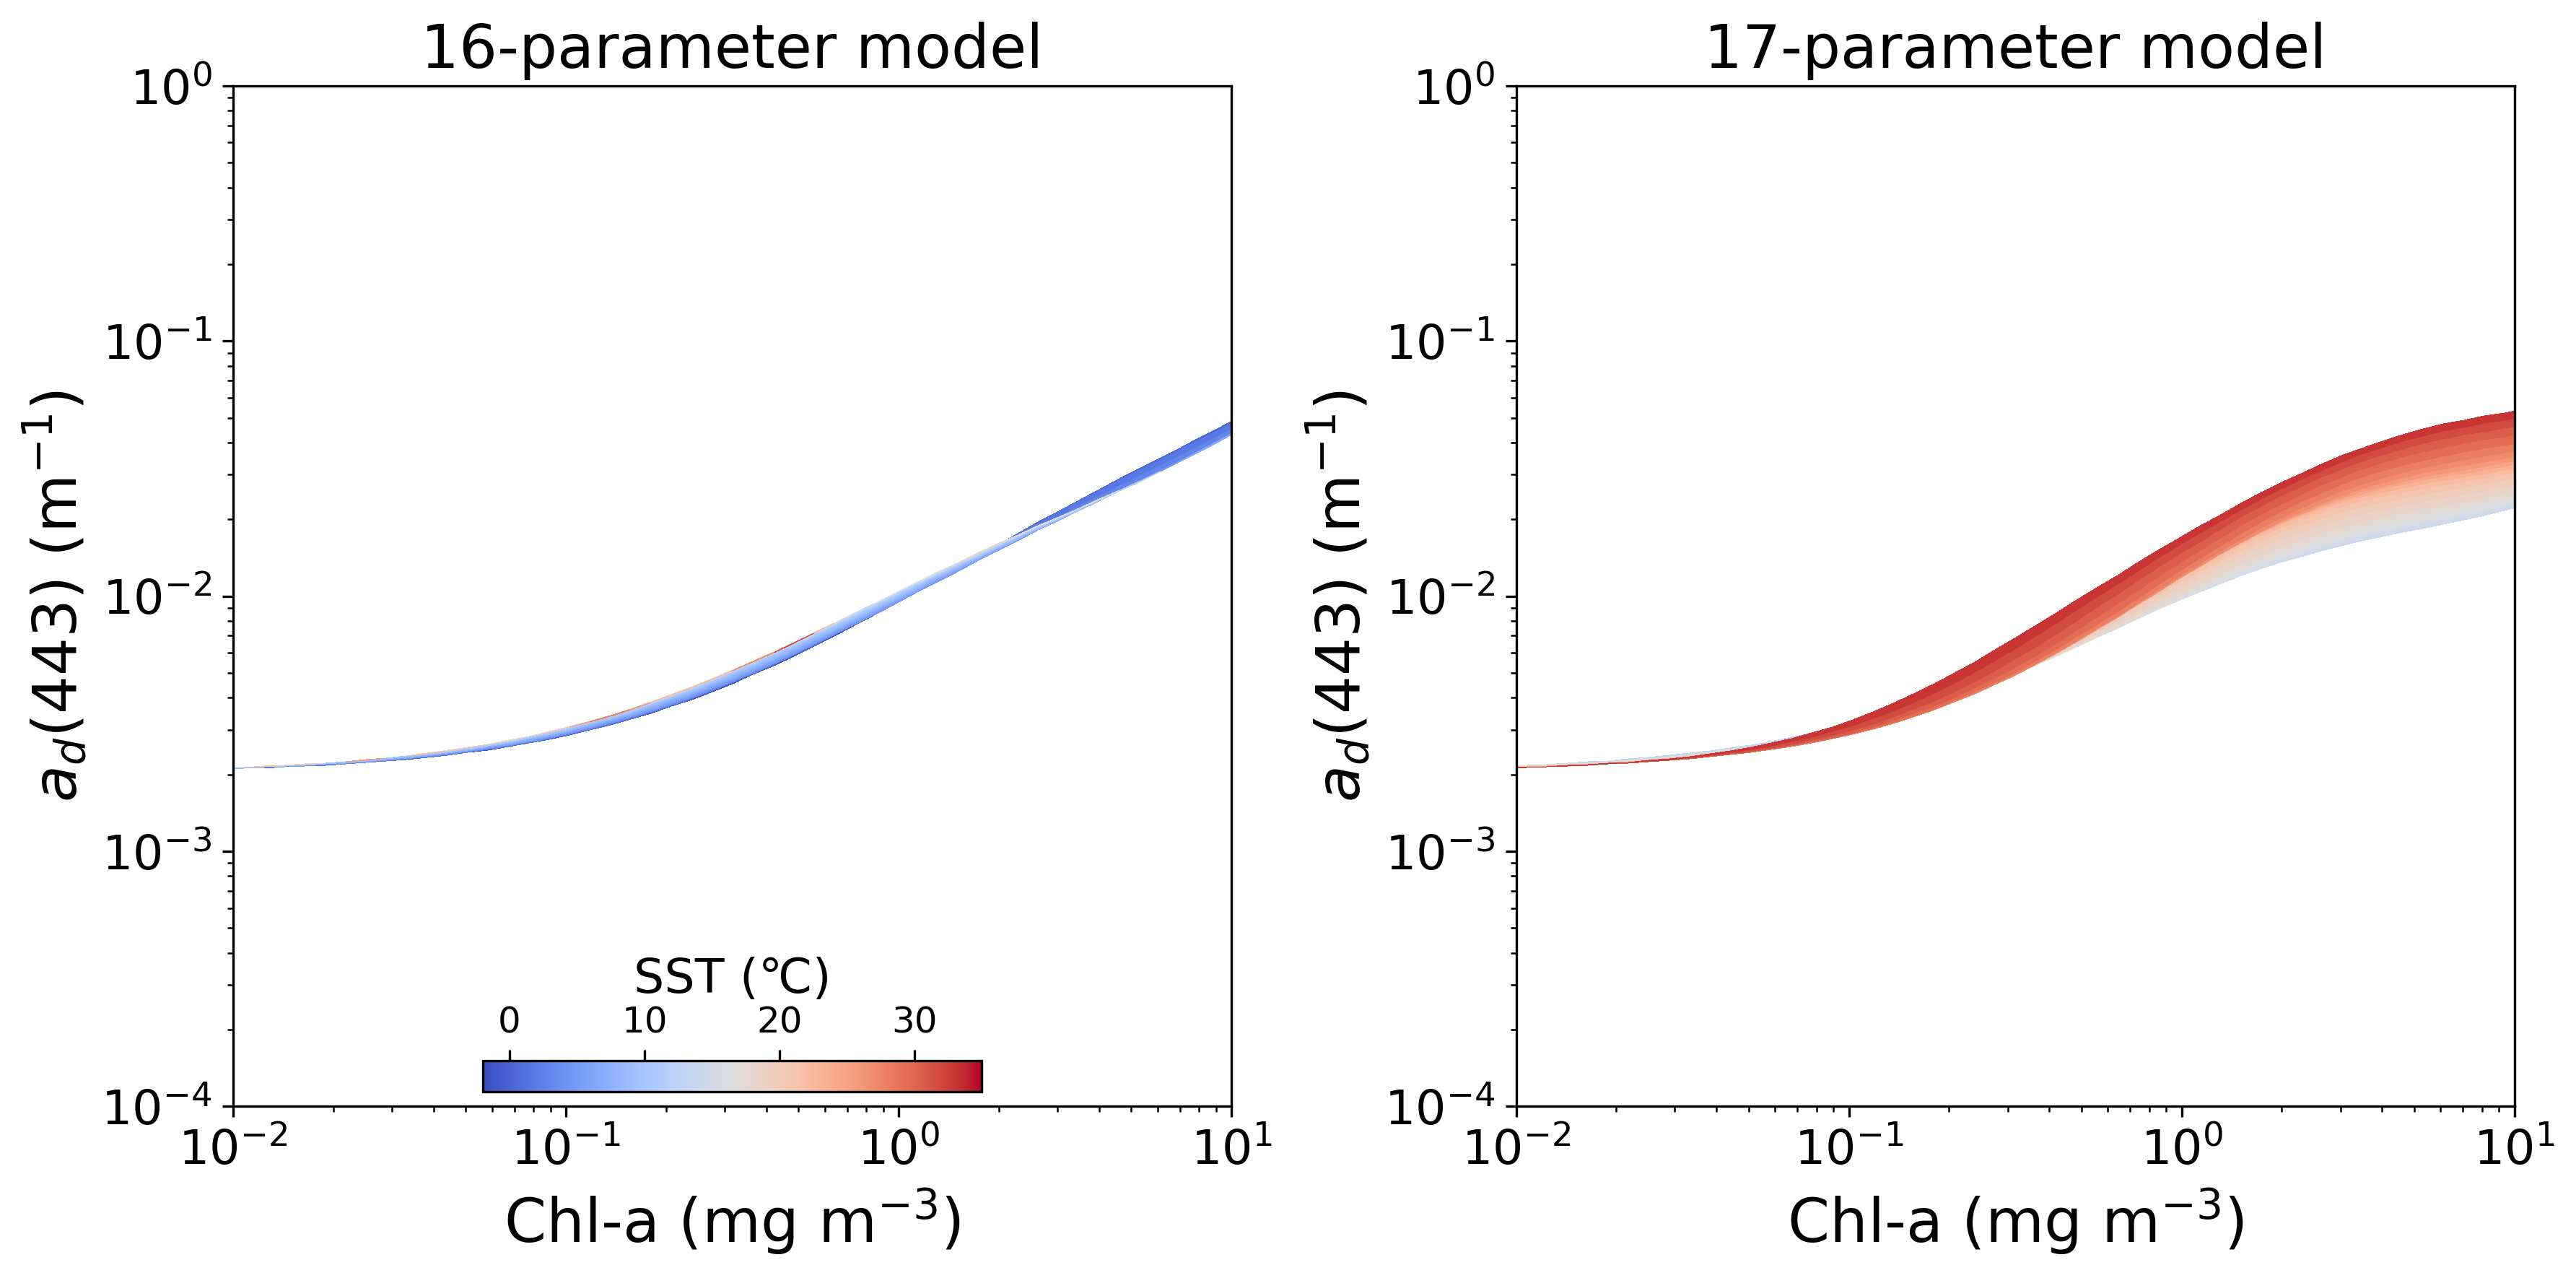

In [62]:
# absorption of NAP-ad
# read chla-specific ad derived from this study
specific_ad_16 = pd.read_excel('input.xlsx', sheet_name='ad_16').iloc[:,1:]
specific_ad_17 = pd.read_excel('input.xlsx', sheet_name='ad_17').iloc[:,1:]

model_ad_16 = np.dot(specific_ad_16.loc[:,'Pico':'Micro'], data_pscs[['Cp_16','Cn_16','Cm_16']].T).T + np.matlib.repmat(specific_ad_16['ak'], len(data), 1)
model_ad_17 = np.dot(specific_ad_17.loc[:,'Pico':'Micro'], data_pscs[['Cp_17','Cn_17','Cm_17']].T).T + np.matlib.repmat(specific_ad_17['ak'], len(data), 1)

model_ad_16 = pd.DataFrame(model_ad_16, columns=[i for i in map(str,wavelength)])  
model_ad_17 = pd.DataFrame(model_ad_17, columns=[i for i in map(str,wavelength)])  

data_ad_16 = copy.deepcopy(data)
data_ad_16 = pd.concat([data_ad_16, model_ad_16], axis=1)

data_ad_17 = copy.deepcopy(data)
data_ad_17 = pd.concat([data_ad_17, model_ad_17], axis=1)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6),dpi=300)

cmap_sst = 'coolwarm'
norm_sst = mpl.colors.Normalize(vmin=-2, vmax=35)

axes[0].pcolormesh(np.reshape(data_ad_16['TChl_a'].values, (num_chla, num_sst)), np.reshape(data_ad_16['443'].values, (num_chla, num_sst)),np.reshape(data_ad_16['SST'].values, (num_chla, num_sst)), cmap=cmap_sst, norm=norm_sst)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Chl-a'+' ($\mathregular{mg~m^{-3}}$)', fontsize = 20)
axes[0].set_ylabel(r'$a_{d}$'+'(443) ($\mathregular{m^{-1}}$)', fontsize = 20)
axes[0].set_xlim([0.01,10])
axes[0].set_ylim([0.0001,1])
axes[0].xaxis.set_tick_params(labelsize=16)
axes[0].yaxis.set_tick_params(labelsize=16)
axes[0].set_title('16-parameter model', fontsize = 20)
axins1 = inset_axes(axes[0],
                    width="50%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower center')

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sst, cmap=cmap_sst), cax=axins1, orientation='horizontal',ticks = [0,10,20,30])
cb.ax.set_xticklabels(['0', '10', '20', '30']) 
cb.set_label(label='SST (℃)', size=16)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=12)

axes[1].pcolormesh(np.reshape(data_ad_17['TChl_a'].values, (num_chla, num_sst)), np.reshape(data_ad_17['443'].values, (num_chla, num_sst)),np.reshape(data_ad_17['SST'].values, (num_chla, num_sst)), cmap=cmap_sst, norm=norm_sst)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Chl-a'+' ($\mathregular{mg~m^{-3}}$)', fontsize = 20)
axes[1].set_ylabel(r'$a_{d}$'+'(443) ($\mathregular{m^{-1}}$)', fontsize = 20)
axes[1].set_xlim([0.01,10])
axes[1].set_ylim([0.0001,1])
axes[1].xaxis.set_tick_params(labelsize=16)
axes[1].yaxis.set_tick_params(labelsize=16)
axes[1].set_title('17-parameter model', fontsize = 20)

fig.tight_layout()

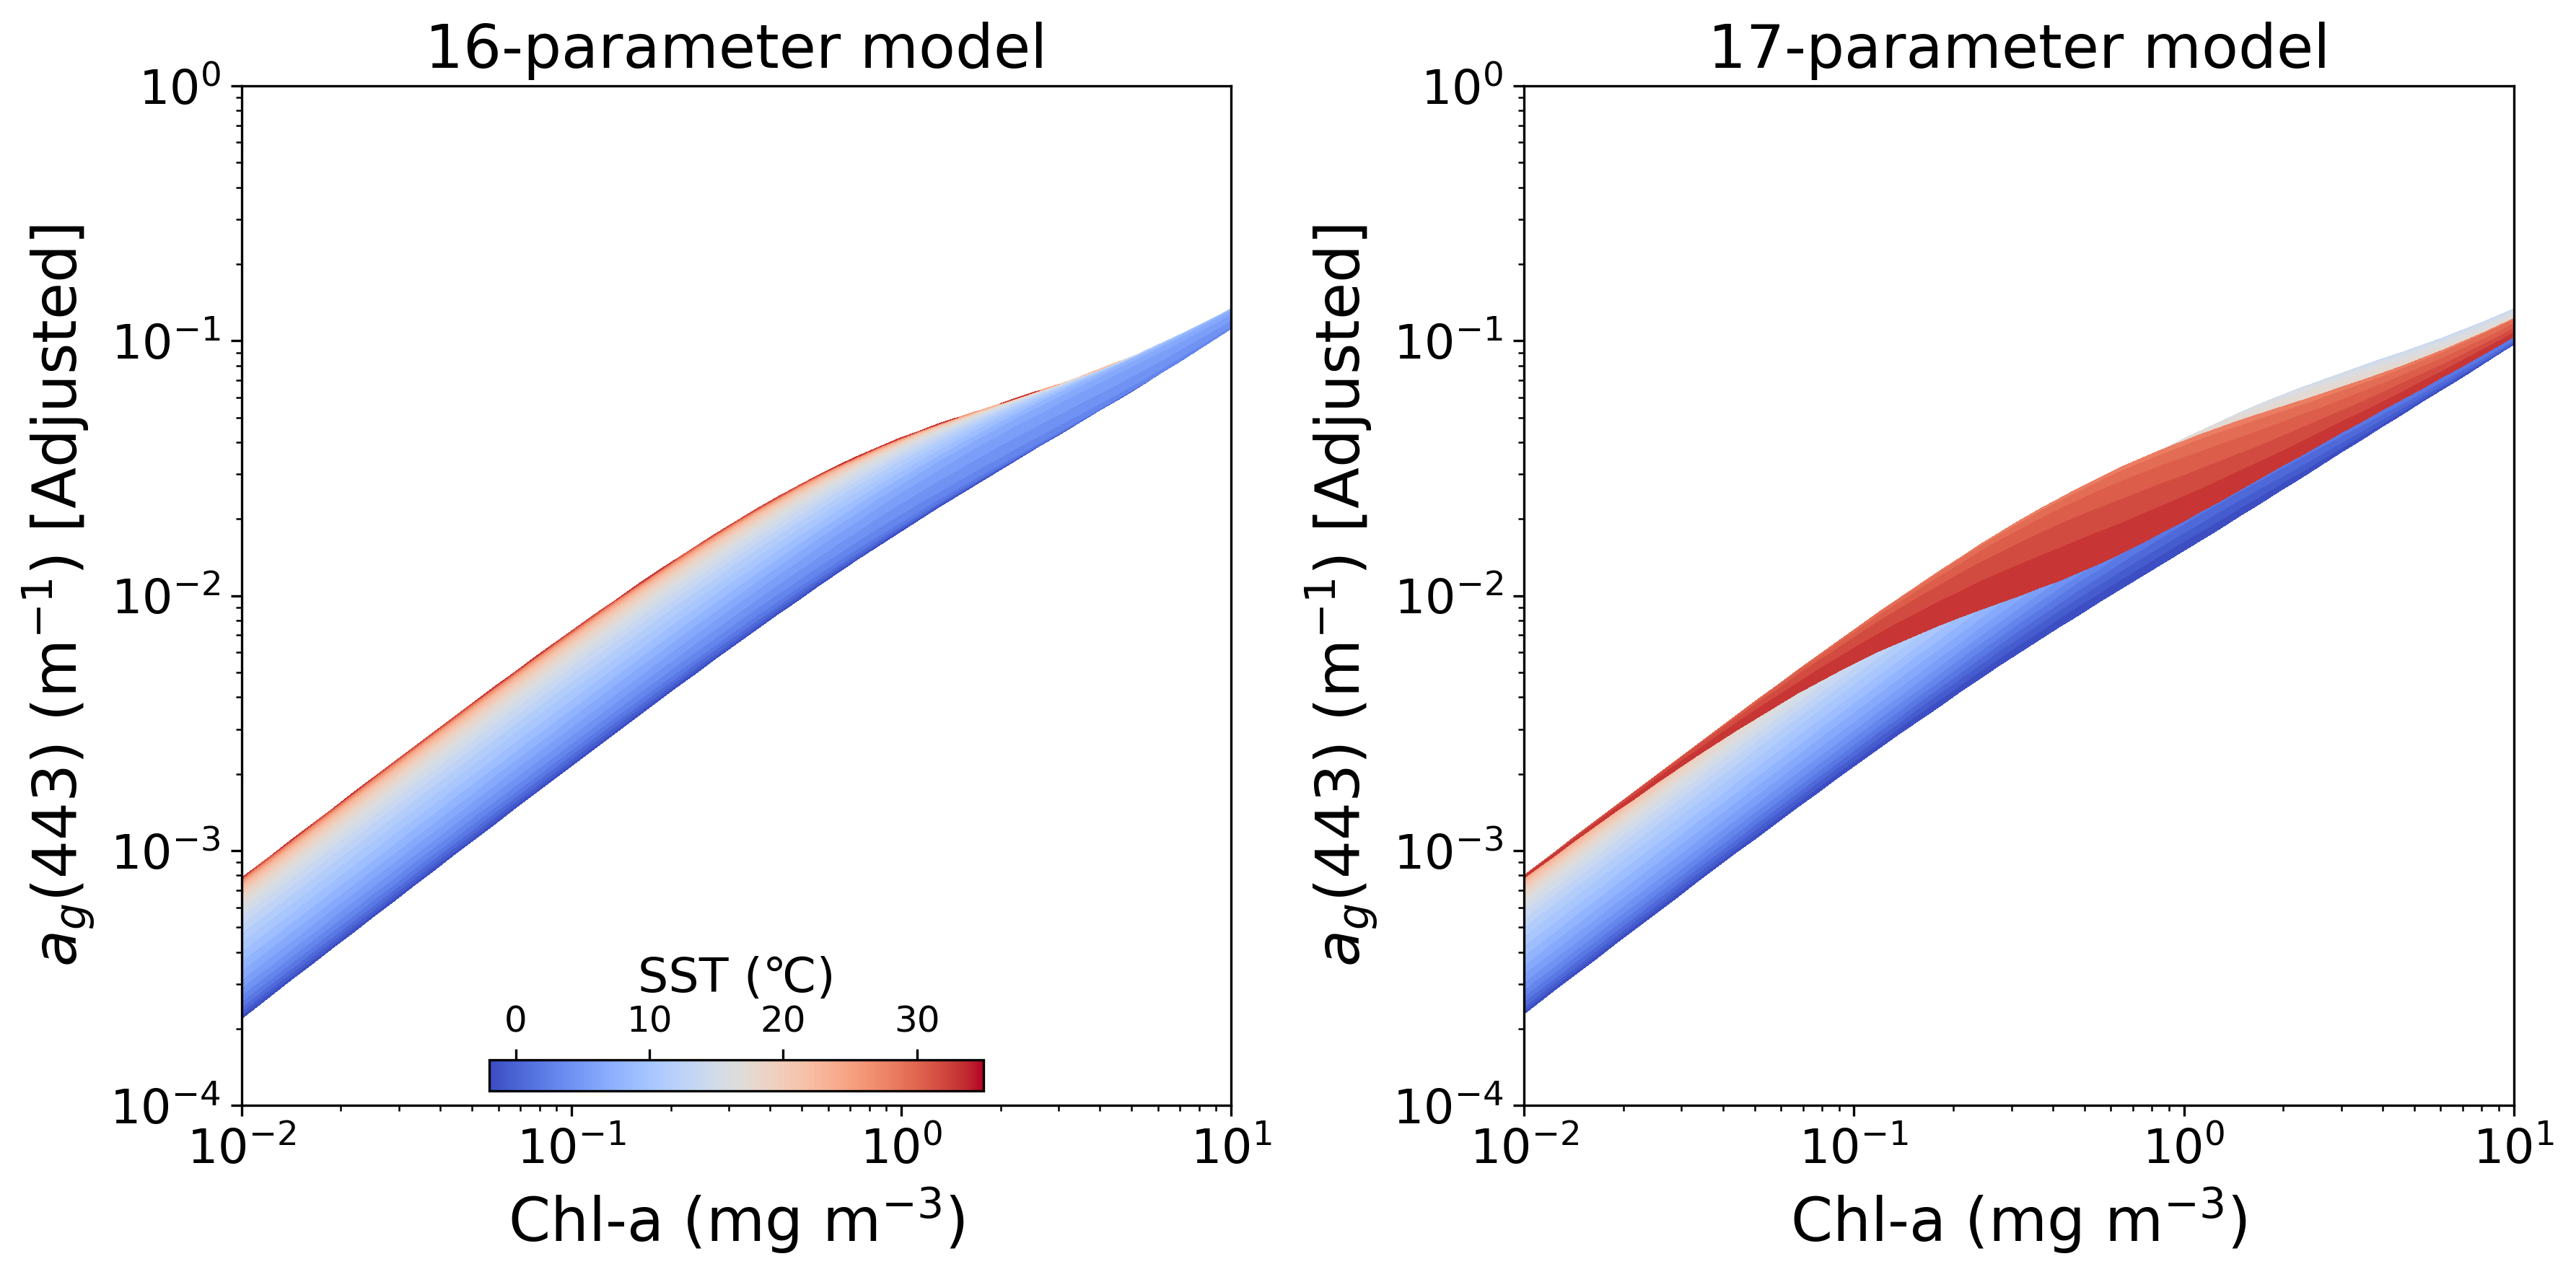

In [63]:
# absorption of CDOM-ag, with adjustion
# read chla-specific ag derived from this study
specific_ag_16 = pd.read_excel('input.xlsx', sheet_name='ag_16').iloc[:,1:]
specific_ag_17 = pd.read_excel('input.xlsx', sheet_name='ag_17').iloc[:,1:]

ratio_16 = pd.read_excel('input.xlsx', sheet_name='ag_fraction_16')
ratio_17 = pd.read_excel('input.xlsx', sheet_name='ag_fraction_17')

ag_select_16 = specific_ag_16*ratio_16['fraction'][0] # ag adjustion
ag_select_17 = specific_ag_17*ratio_17['fraction'][0] # ag adjustion

model_ag_16 = np.dot(ag_select_16.loc[:,'Pico':'Micro'], data_pscs[['Cp_16','Cn_16','Cm_16']].T).T
model_ag_17 = np.dot(ag_select_17.loc[:,'Pico':'Micro'], data_pscs[['Cp_17','Cn_17','Cm_17']].T).T

model_ag_16 = pd.DataFrame(model_ag_16, columns=[i for i in map(str,wavelength)])  
model_ag_17 = pd.DataFrame(model_ag_17, columns=[i for i in map(str,wavelength)])  

data_ag_16 = copy.deepcopy(data)
data_ag_16 = pd.concat([data_ag_16, model_ag_16], axis=1)

data_ag_17 = copy.deepcopy(data)
data_ag_17 = pd.concat([data_ag_17, model_ag_17], axis=1)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6),dpi=300)

cmap_sst = 'coolwarm'
norm_sst = mpl.colors.Normalize(vmin=-2, vmax=35)

axes[0].pcolormesh(np.reshape(data_ag_16['TChl_a'].values, (num_chla, num_sst)), np.reshape(data_ag_16['443'].values, (num_chla, num_sst)),np.reshape(data_ag_16['SST'].values, (num_chla, num_sst)), cmap=cmap_sst, norm=norm_sst)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Chl-a'+' ($\mathregular{mg~m^{-3}}$)', fontsize = 20)
axes[0].set_ylabel(r'$a_{g}$'+'(443) ($\mathregular{m^{-1}}$) [Adjusted]', fontsize = 20)
axes[0].set_xlim([0.01,10])
axes[0].set_ylim([0.0001,1])
axes[0].xaxis.set_tick_params(labelsize=16)
axes[0].yaxis.set_tick_params(labelsize=16)
axes[0].set_title('16-parameter model', fontsize = 20)
axins1 = inset_axes(axes[0],
                    width="50%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower center')

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sst, cmap=cmap_sst), cax=axins1, orientation='horizontal',ticks = [0,10,20,30])
cb.ax.set_xticklabels(['0', '10', '20', '30']) 
cb.set_label(label='SST (℃)', size=16)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=12)

axes[1].pcolormesh(np.reshape(data_ag_17['TChl_a'].values, (num_chla, num_sst)), np.reshape(data_ag_17['443'].values, (num_chla, num_sst)),np.reshape(data_ag_17['SST'].values, (num_chla, num_sst)), cmap=cmap_sst, norm=norm_sst)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Chl-a'+' ($\mathregular{mg~m^{-3}}$)', fontsize = 20)
axes[1].set_ylabel(r'$a_{g}$'+'(443) ($\mathregular{m^{-1}}$) [Adjusted]', fontsize = 20)
axes[1].set_xlim([0.01,10])
axes[1].set_ylim([0.0001,1])
axes[1].xaxis.set_tick_params(labelsize=16)
axes[1].yaxis.set_tick_params(labelsize=16)
axes[1].set_title('17-parameter model', fontsize = 20)

fig.tight_layout()

In [55]:
# total absorption
total_a_16 = data_aw.loc[:,'700':'400'] + data_aph_16.loc[:,'700':'400'] + data_ad_16.loc[:,'700':'400'] + data_ag_16.loc[:,'700':'400']
total_a_17 = data_aw.loc[:,'700':'400'] + data_aph_17.loc[:,'700':'400'] + data_ad_17.loc[:,'700':'400'] + data_ag_17.loc[:,'700':'400']

### Backscattering
The total backscattering coefficients, $b_b(\lambda)$, can be expressed as the additive sum of backsacttering coefficients of pure water and particles, such as: $b_b(\lambda)~=~b_{bw}(\lambda)~+~b_{bp}(\lambda)$

In [64]:
# backscattering of water-bbw (Zhang and Hu, 2009, https://doi.org/10.1364/OE.17.001671; Zhang et al., 2009, https://doi.org/10.1364/OE.17.005698)
bsw = np.zeros((len(data), len(wavelength)))*np.nan
for i in range(0,len(data),1):
    bsw[i,:] = betasw124_ZHH2009.betasw124_ZHH2009(wavelength, data.Salinity[i], data.SST[i])[1]
    
bbw = bsw/2
bbw = pd.DataFrame(bbw, columns=[i for i in map(str,wavelength)])    

data_bbw = copy.deepcopy(data)
data_bbw = pd.concat([data_bbw, bbw], axis=1)

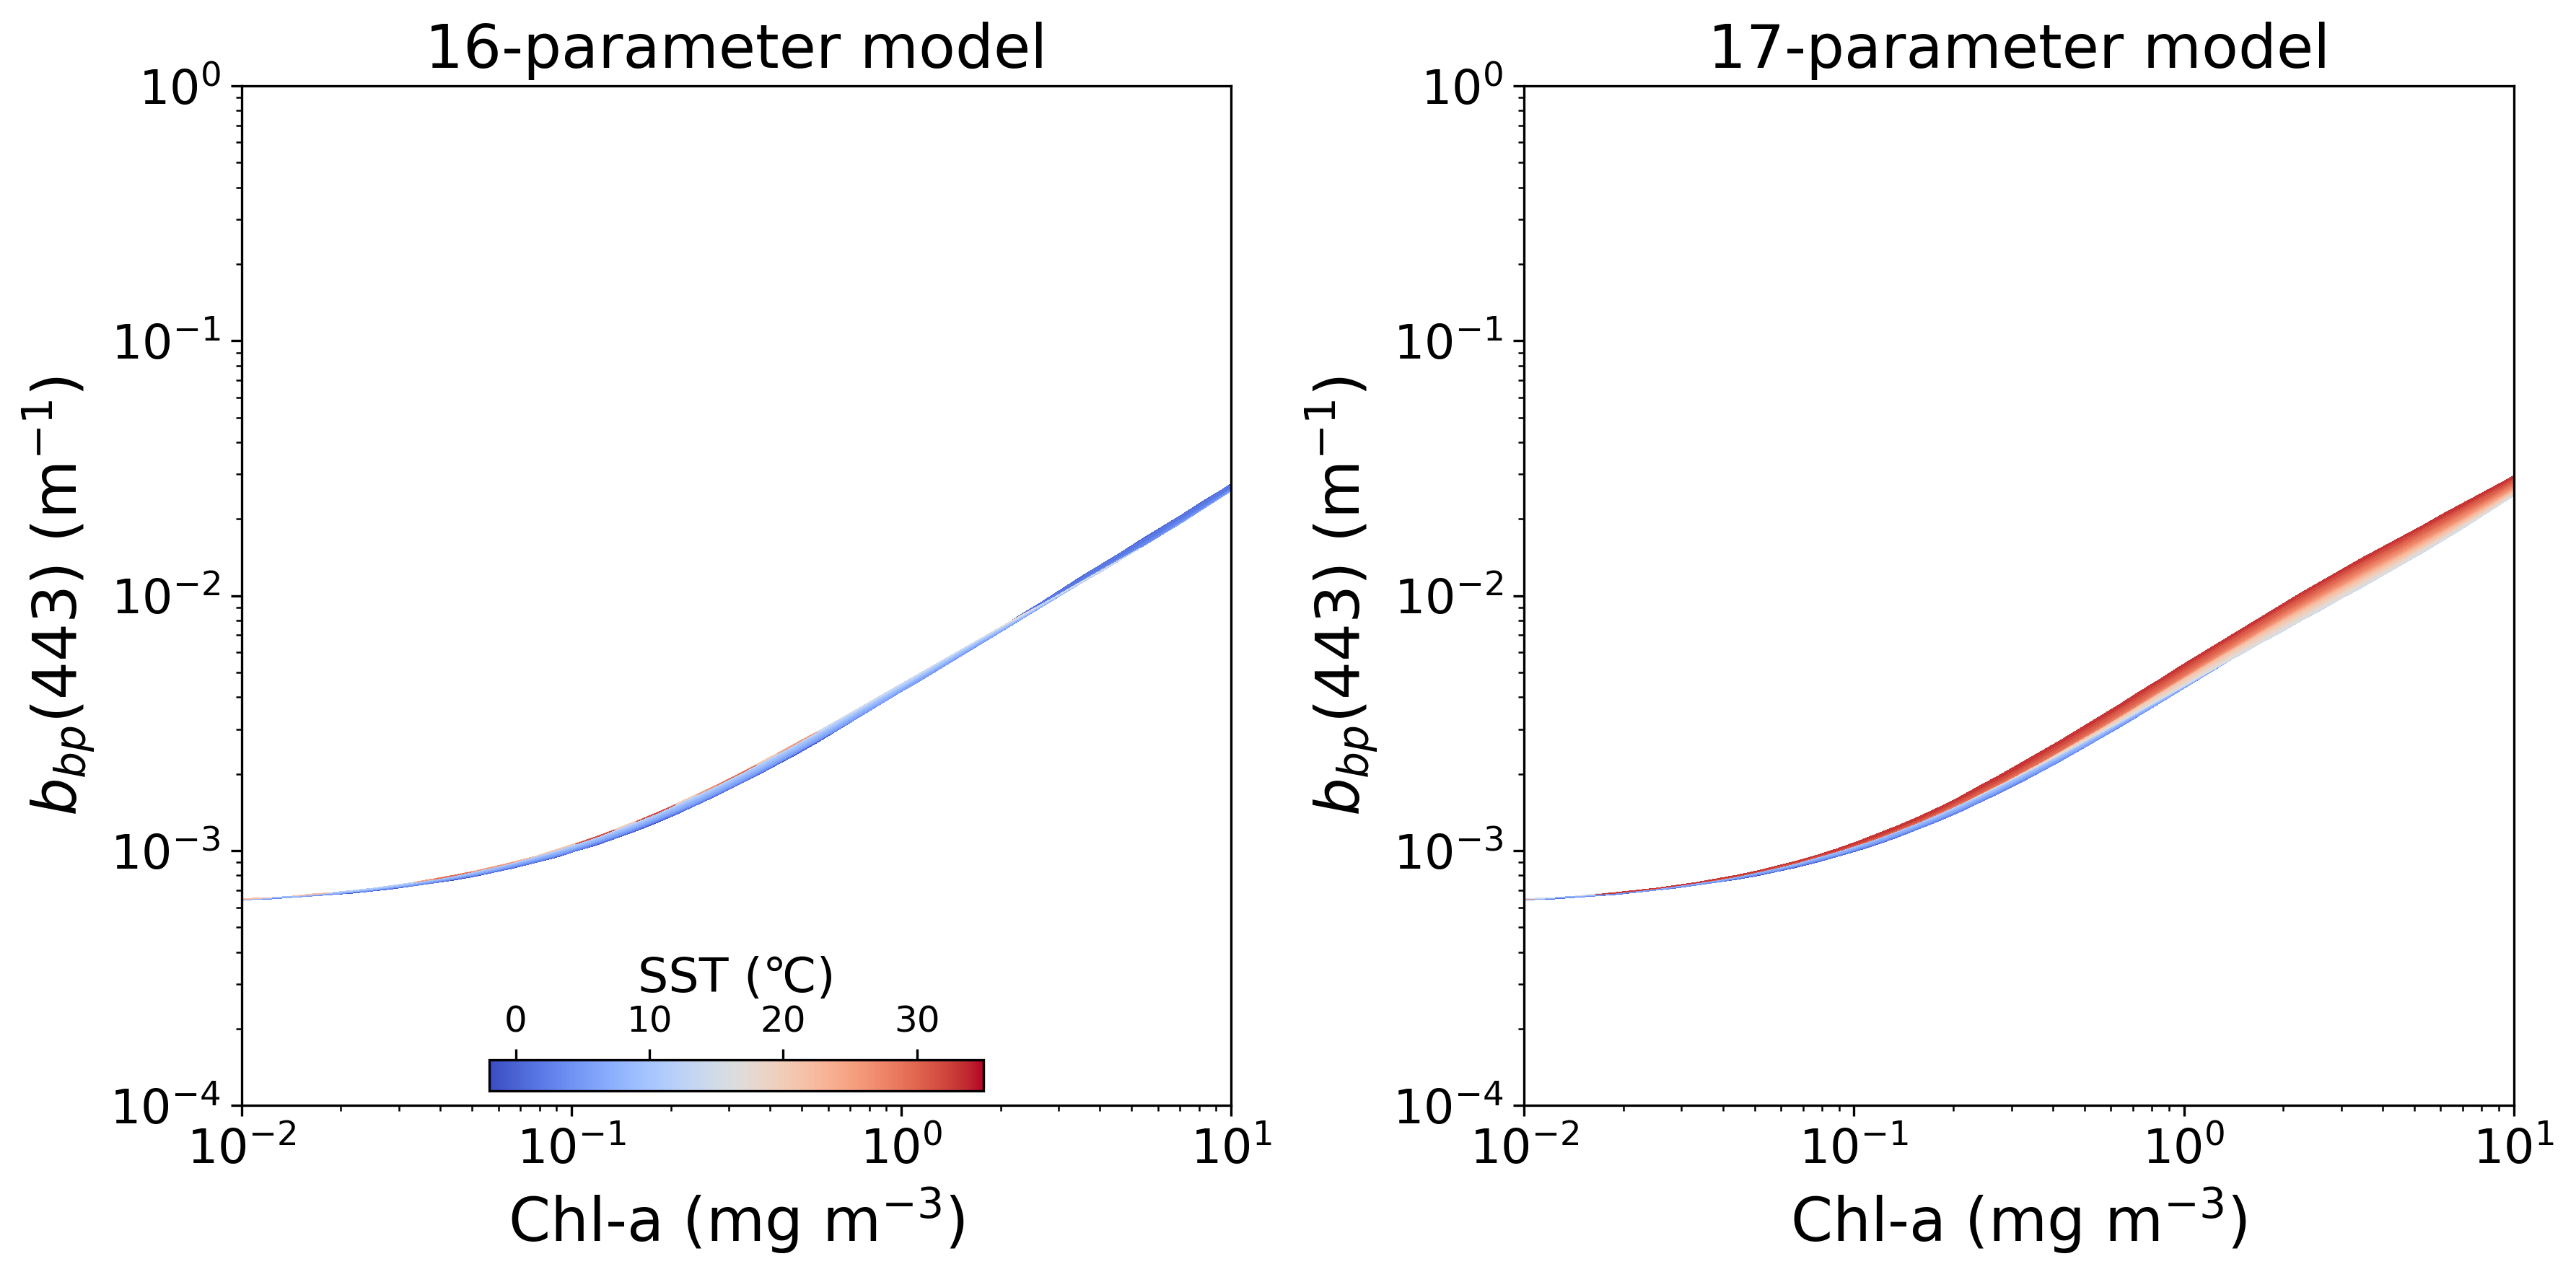

In [65]:
# backscattering of particles-bbp
# read chla-specific bbp derived from this study
specific_bbp_16 = pd.read_excel('input.xlsx', sheet_name='bbp_16').iloc[:,1:]
specific_bbp_17 = pd.read_excel('input.xlsx', sheet_name='bbp_17').iloc[:,1:]

model_bbp_16 = np.dot(specific_bbp_16.loc[:,'Pico':'Micro'], data_pscs[['Cp_16','Cn_16','Cm_16']].T).T + np.matlib.repmat(specific_bbp_16['bbk'], len(data), 1)
model_bbp_17 = np.dot(specific_bbp_17.loc[:,'Pico':'Micro'], data_pscs[['Cp_17','Cn_17','Cm_17']].T).T + np.matlib.repmat(specific_bbp_17['bbk'], len(data), 1)

model_bbp_16 = pd.DataFrame(model_bbp_16, columns=[i for i in map(str,wavelength)])  
model_bbp_17 = pd.DataFrame(model_bbp_17, columns=[i for i in map(str,wavelength)])  

data_bbp_16 = copy.deepcopy(data)
data_bbp_16 = pd.concat([data_bbp_16, model_bbp_16], axis=1)

data_bbp_17 = copy.deepcopy(data)
data_bbp_17 = pd.concat([data_bbp_17, model_bbp_17], axis=1)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6),dpi=300)

cmap_sst = 'coolwarm'
norm_sst = mpl.colors.Normalize(vmin=-2, vmax=35)

axes[0].pcolormesh(np.reshape(data_bbp_16['TChl_a'].values, (num_chla, num_sst)), np.reshape(data_bbp_16['443'].values, (num_chla, num_sst)),np.reshape(data_bbp_16['SST'].values, (num_chla, num_sst)), cmap=cmap_sst, norm=norm_sst)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Chl-a'+' ($\mathregular{mg~m^{-3}}$)', fontsize = 20)
axes[0].set_ylabel(r'$b_{bp}$'+'(443) ($\mathregular{m^{-1}}$)', fontsize = 20)
axes[0].set_xlim([0.01,10])
axes[0].set_ylim([0.0001,1])
axes[0].xaxis.set_tick_params(labelsize=16)
axes[0].yaxis.set_tick_params(labelsize=16)
axes[0].set_title('16-parameter model', fontsize = 20)
axins1 = inset_axes(axes[0],
                    width="50%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower center')

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sst, cmap=cmap_sst), cax=axins1, orientation='horizontal',ticks = [0,10,20,30])
cb.ax.set_xticklabels(['0', '10', '20', '30']) 
cb.set_label(label='SST (℃)', size=16)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=12)

axes[1].pcolormesh(np.reshape(data_bbp_17['TChl_a'].values, (num_chla, num_sst)), np.reshape(data_bbp_17['443'].values, (num_chla, num_sst)),np.reshape(data_bbp_17['SST'].values, (num_chla, num_sst)), cmap=cmap_sst, norm=norm_sst)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Chl-a'+' ($\mathregular{mg~m^{-3}}$)', fontsize = 20)
axes[1].set_ylabel(r'$b_{bp}$'+'(443) ($\mathregular{m^{-1}}$)', fontsize = 20)
axes[1].set_xlim([0.01,10])
axes[1].set_ylim([0.0001,1])
axes[1].xaxis.set_tick_params(labelsize=16)
axes[1].yaxis.set_tick_params(labelsize=16)
axes[1].set_title('17-parameter model', fontsize = 20)

fig.tight_layout()

In [66]:
# total backscattering
total_bb_16 = data_bbw.loc[:,'700':'400'] + data_bbp_16.loc[:,'700':'400']
total_bb_17 = data_bbw.loc[:,'700':'400'] + data_bbp_17.loc[:,'700':'400']

### Remote sensing of reflectance 
Using a forward model that explicitly considers the particle and molecule scattering phase-function effects (Lee et al., 2013, https://doi.org/10.1002/jgrc.20308), the remote sensing reflectance, $R_{rs}(\lambda)$, can be estimated from the total absorption and total backscattering coefficients mentioned above, such as: $R_{rs}(\lambda, \Omega)~=~(G^w_0(\Omega)~+~G^w_1(\Omega)~\frac{b_{bw}(\lambda)}{\kappa(\lambda)})~\frac{b_{bw}(\lambda)}{\kappa(\lambda)}~+~(G^p_0(\Omega)~+~G^p_1(\Omega)~\frac{b_{bp}(\lambda)}{\kappa(\lambda)})~\frac{b_{bp}(\lambda)}{\kappa(\lambda)}$

In [67]:
# calculate Rrs
k_16 = total_a_16 + total_bb_16
Rrs_16 = (0.0604+0.0406*(data_bbw.loc[:,'700':'400']/k_16))*(data_bbw.loc[:,'700':'400']/k_16)+(0.0402+0.1310*(data_bbp_16.loc[:,'700':'400']/k_16))*(data_bbp_16.loc[:,'700':'400']/k_16)

k_17 = total_a_17 + total_bb_17
Rrs_17 = (0.0604+0.0406*(data_bbw.loc[:,'700':'400']/k_17))*(data_bbw.loc[:,'700':'400']/k_17)+(0.0402+0.1310*(data_bbp_17.loc[:,'700':'400']/k_17))*(data_bbp_17.loc[:,'700':'400']/k_17)

Rrs_16.columns = ['Rrs_'+ i for i in map(str,wavelength)]
data_Rrs_16 = pd.concat([data,Rrs_16], axis=1)

Rrs_17.columns = ['Rrs_'+ i for i in map(str,wavelength)]
data_Rrs_17 = pd.concat([data,Rrs_17], axis=1)

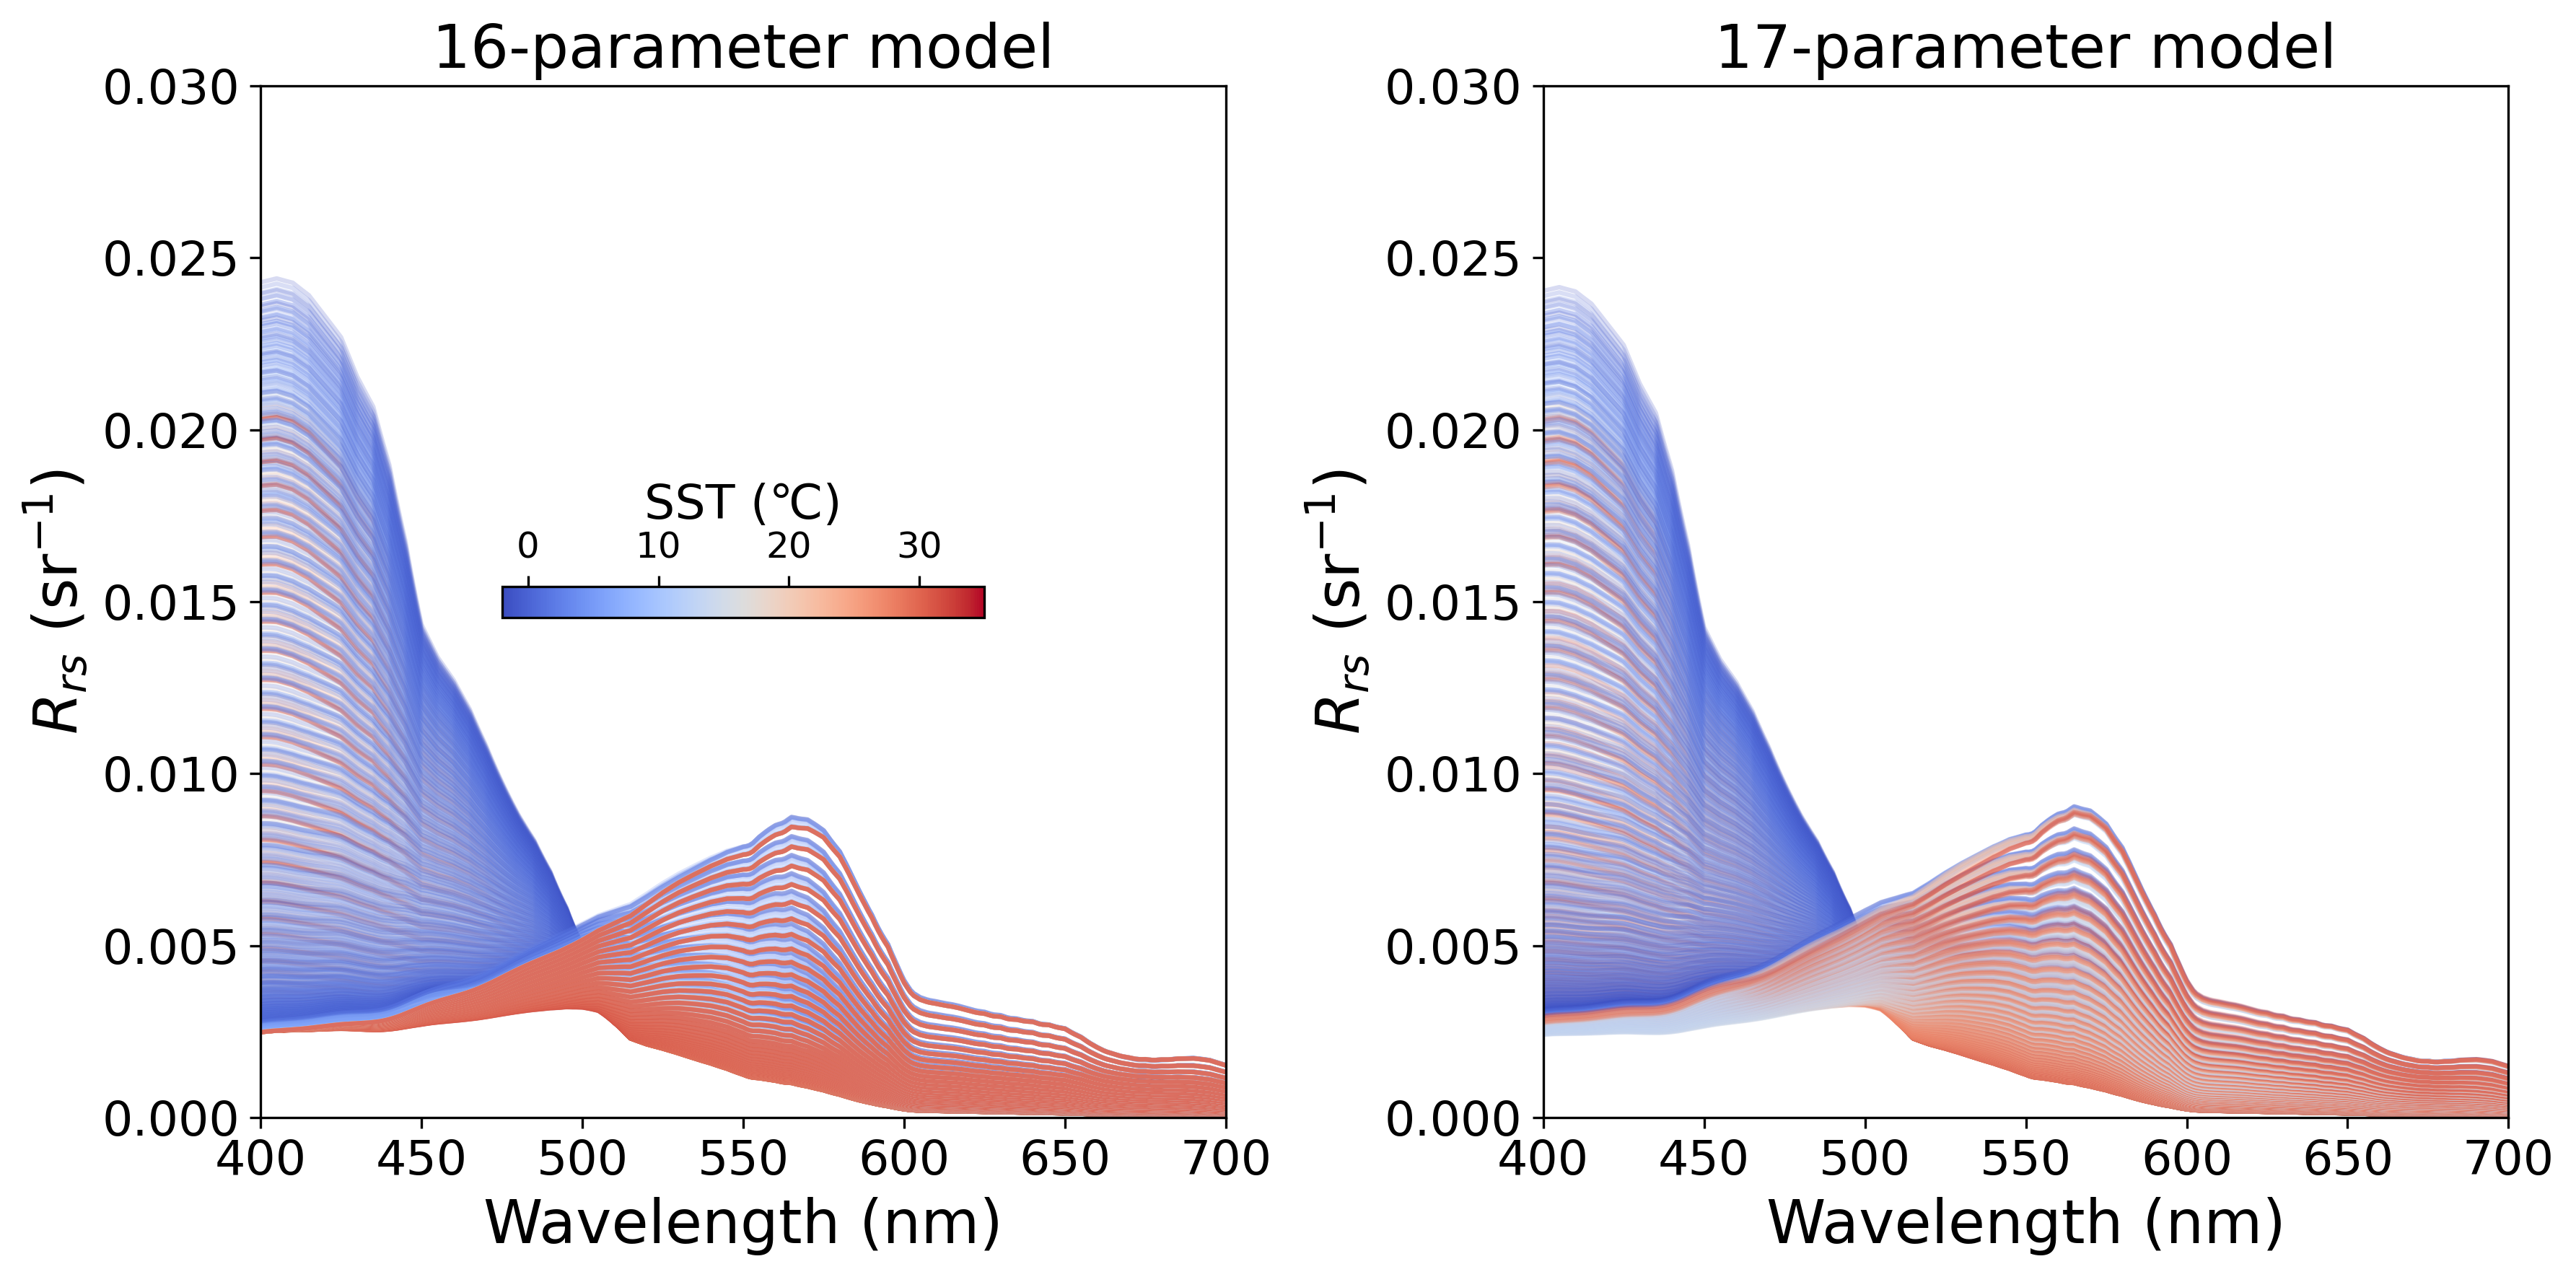

In [72]:
# plot Rrs
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6),dpi=300)
cmap_sst = plt.get_cmap('coolwarm')
norm_sst = mpl.colors.Normalize(vmin=-2, vmax=35)

for i in range(0, len(data_Rrs_16)):
    color = cmap_sst(norm_sst(data_Rrs_16['SST'].iloc[i]))
    axes[0].plot(np.arange(700, 399, -1), data_Rrs_16.loc[i,'Rrs_700':'Rrs_400'], c=color, alpha=0.2)    
axes[0].set_xlabel('Wavelength'+' (nm)', fontsize = 20)
axes[0].set_ylabel(r'$R_{rs}$'+' ($\mathregular{sr^{-1}}$)', fontsize = 20)
axes[0].set_xlim([400,700])
axes[0].set_ylim([0, 0.03])
axes[0].xaxis.set_tick_params(labelsize=16)
axes[0].yaxis.set_tick_params(labelsize=16)
axes[0].set_title('16-parameter model', fontsize = 20)
axins1 = inset_axes(axes[0],
                    width="50%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='center')
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sst, cmap=cmap_sst), cax=axins1, orientation='horizontal',ticks = [0,10,20,30])
cb.ax.set_xticklabels(['0', '10', '20', '30']) 
cb.set_label(label='SST (℃)', size=16)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(labelsize=12)

for i in range(0, len(data_Rrs_17)):
    color = cmap_sst(norm_sst(data_Rrs_17['SST'].iloc[i]))
    axes[1].plot(np.arange(700, 399, -1), data_Rrs_17.loc[i,'Rrs_700':'Rrs_400'], c=color, alpha=0.2)    
axes[1].set_xlabel('Wavelength'+' (nm)', fontsize = 20)
axes[1].set_ylabel(r'$R_{rs}$'+' ($\mathregular{sr^{-1}}$)', fontsize = 20)
axes[1].set_xlim([400,700])
axes[1].set_ylim([0, 0.03])
axes[1].xaxis.set_tick_params(labelsize=16)
axes[1].yaxis.set_tick_params(labelsize=16)
axes[1].set_title('17-parameter model', fontsize = 20)

fig.tight_layout()